# <span style="color:#820747">4. Modeling. Data Scientist and Business Analyst prediction.
                                                                                             by Pavel Tarasenko

# <span style="color:#6e750e">Navigator:

<b>[1. WebScraping](./1_WebScraping-and-Cleaning-Data.ipynb)

<b>[2. My EDA](./2_EDA.ipynb)

<b>[3. Salary Prediction](./3_MODELING_Part1.ipynb)

<b>[5. TECHNICAL REPORT](./Technical_report.txt)

<b>[6. NON TECHNICAL REPORT](./Non_technical_report.txt)

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">In this part I will do modeling to predict Data scientist job or Business Analyst job. Job position will be predicted as 0 and 1, where 0 is Business Analyst and 1 is Data Scientist. I will use NLP to find predictors from summary and job_bio, also I will use cities as a dummy variables. I will use DecisionTreeClassifier, LogisticRegression, SVM models. 

In [1]:
# Import all necessary libraries.
# -----------------------------------------------------
import matplotlib.pyplot as plt
import pandas as pd
import bs4
import re
import time
import numpy as np
import sklearn
from time import sleep
import requests
import seaborn as sns

from statistics import median
import matplotlib as mpl
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib.request, urllib.parse, urllib.error

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
# Load my data into df. 
# -----------------------------------------------------
df = pd.read_csv('ALL_SALARY_PREDICTED.csv')

In [3]:
df.head(2)

,Unnamed: 0,location,title,company,salary,Salary_type,summary,job_bio,level,Salary_grater_median
0,0,sydney,data science research engineer,macquarie university,106382.0,year,we are seeking a data science research enginee...,macquarie is the university of pioneering mind...,middle,0.0
1,1,sydney,senior software engineer machine learning,rokt,137500.0,year,a strong statistical background and or experie...,exceptional opportunity to join one of the fas...,senior,1.0


In [4]:
df.isnull().sum()

Unnamed: 0                 0
location                   0
title                      0
company                    0
salary                  3570
Salary_type             3570
summary                    0
job_bio                    0
level                      0
Salary_grater_median       0
dtype: int64

In [5]:
# Drop unneeded columns.
# -----------------------------------------------------
df.drop(['salary', 'Salary_type', 'Unnamed: 0'], axis=1, inplace=True)

In [6]:
# Now our data doesnt include any nuls.
# -----------------------------------------------------
df.isnull().sum()

location                0
title                   0
company                 0
summary                 0
job_bio                 0
level                   0
Salary_grater_median    0
dtype: int64

In [7]:
df.head(1)

,location,title,company,summary,job_bio,level,Salary_grater_median
0,sydney,data science research engineer,macquarie university,we are seeking a data science research enginee...,macquarie is the university of pioneering mind...,middle,0.0


In [8]:
# Put senior data scientist in a same group with datascientist and senior data 
df['title'] = df['title'].map(lambda x: 'data scientist' if 'senior data scientist' in x else x)
df['title'] = df['title'].map(lambda x: 'business analyst' if 'senior business analyst' in x else x)

In [9]:
# Now I have 89 Ds and 293 Ba
# -----------------------------------------------------
df.title.value_counts().head(3)

business analyst    293
data scientist       89
data analyst         82
Name: title, dtype: int64

In [10]:
# Get data only from this 2 job titles.
# -----------------------------------------------------
df2 = df[(df['title'] == 'data scientist') | (df['title'] =='business analyst')]

In [11]:
df2.shape

(382, 7)

In [12]:
# Make dummy variables for the title. data scientist = 1
# -----------------------------------------------------
df2['title'] = df['title'].map(lambda x: 1 if 'data scientist' in x else 0)

/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [13]:
df2.head(3)

,location,title,company,summary,job_bio,level,Salary_grater_median
9,sydney,1,morgan mckinley,the time has come to step up and be counted as...,calling all senior data scientists the ti...,senior,1.0
10,sydney,1,morgan mckinley,my client a well established australian insti...,utilise your data science skill set across a v...,middle,0.0
11,sydney,1,nakama,data extraction old new limited and huge d...,mature data science practice rapidly expanding...,middle,1.0


<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> From here I will start using NLP to get my predictors for future use in my Models to predict DataScientist and Bussines Analyst. Also I loc my 1 dimensional target. 

In [14]:
# Set my target variable.
# -----------------------------------------------------
target = df2.iloc[::,1]

In [15]:
target.head(10)

9     1
10    1
11    1
16    1
42    1
43    1
52    1
58    1
67    0
68    0
Name: title, dtype: int64

# <span style="color:#15b01a"> Search for words in summary

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">Fit my count vectorizer to the summary and make our summary data into company_train variable. I remove some unneeded words with 'stop_words='english', I set 'ngram_range = (1, 3)' to go through all combination words max 3 words. 'min_df I set 0.04 which will show me only word which appears more than 0.4% in a text.

In [16]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df = .04)
cvec.fit(df2['summary'])
company_train = pd.DataFrame(cvec.transform(df2['summary']).todense(), columns=cvec.get_feature_names())
company_train.head(6)

,ability,analysis,analyst,analyst join,analysts,analytics,based,big,big data,business,...,senior business analyst,skills,strong,support,team,teams,work,working,years,years experience
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [17]:
words_to_target_summary = pd.concat([company_train, target], axis=1)

In [18]:
for i in range(2):
    word_count = words_to_target_summary[words_to_target_summary["title"] == i].sum(axis=0)
    print(i), "most common words"
    w = word_count.sort_values(ascending = False).head(10)
    print(w)
    print('')

0
business               36.0
data                   22.0
analyst                19.0
business analyst       18.0
experience             12.0
looking                 6.0
experience business     6.0
analytics               5.0
analysis                5.0
years experience        4.0
dtype: float64

1
title                      89.0
data                       17.0
business                   12.0
analyst                     9.0
business analyst            8.0
senior                      5.0
senior business analyst     4.0
senior business             4.0
analytics                   4.0
experience                  4.0
dtype: float64



In [19]:
word_business_analyst = words_to_target_summary[words_to_target_summary["title"] == 0].sum(axis = 0)
word_data_scientist = words_to_target_summary[words_to_target_summary["title"] == 1].sum(axis = 0)

word_count_compare = pd.DataFrame([word_business_analyst, word_data_scientist]).T

word_count_compare["above_below_ratio"] = word_count_compare[1] / word_count_compare[0]
word_count_compare.above_below_ratio.sort_values(ascending=False)

title                                inf
data analysis                        inf
projects                             inf
organisation                         inf
reporting                            inf
commercial                      2.000000
senior business analyst         2.000000
senior business                 2.000000
senior                          1.666667
data analytics                  1.000000
data science                    1.000000
requirements                    1.000000
development                     1.000000
experienced                     1.000000
business requirements           1.000000
based                           1.000000
data scientist                  1.000000
ability                         1.000000
science                         1.000000
scientist                       1.000000
teams                           1.000000
analytics                       0.800000
data                            0.772727
team                            0.666667
join            

In [20]:
# Top words related to data scientist position and low relatet to bussines analyst position.
# -----------------------------------------------------
#top 8 = senior, data analytics, data science, requirements, development, science, scientist, data
#low 8 = experienced business, project, strong, support, customer, client, analysts, process

# <span style="color:#15b01a">Search for words in job_bio

In [21]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df = .10)
cvec.fit(df2['job_bio'])
company_train = pd.DataFrame(cvec.transform(df2['job_bio']).todense(), columns=cvec.get_feature_names())

In [22]:
words_to_target_jobbio = pd.concat([company_train, target], axis=1)
words_to_target_jobbio.head(3)

,02,12,12 days,13,13 days,14,14 days,16,16 days,17,...,work closely,working,workshops,world,writing,written,written verbal,years,years experience,title
0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN


In [23]:
for i in range(2):
    word_count = words_to_target_jobbio[words_to_target_jobbio["title"] == i].sum(axis=0)
    print(i), "most common words"
    w = word_count.sort_values(ascending = False).head(10)
    print(w)
    print('')

0
window              788.0
false               372.0
false window        355.0
business            270.0
ago                 200.0
days ago            151.0
days                151.0
analyst             147.0
melbourne           146.0
business analyst    141.0
dtype: float64

1
window          354.0
false           161.0
false window    153.0
data            111.0
business        100.0
ago              91.0
title            89.0
apply            81.0
days             64.0
days ago         64.0
dtype: float64



In [24]:
word_business_analyst = words_to_target_jobbio[words_to_target_jobbio["title"] == 0].sum(axis = 0)
word_data_scientist = words_to_target_jobbio[words_to_target_jobbio["title"] == 1].sum(axis = 0)

word_count_compare = pd.DataFrame([word_business_analyst, word_data_scientist]).T

word_count_compare["above_below_ratio"] = word_count_compare[1] / word_count_compare[0]
word_count_compare.above_below_ratio.sort_values(ascending=False)

title                            inf
attention                        inf
resources sydney                 inf
paxus sydney                     inf
nsw paxus                        inf
intelligence                     inf
sydney central                   inf
ensuring                         inf
district nsw                     inf
high quality                     inf
state                       5.000000
greythorn specialist        4.000000
achieve                     4.000000
specialist technology       4.000000
technology recruitment      4.000000
learning                    3.125000
programming                 3.000000
problem solving             3.000000
quantitative                3.000000
solving                     3.000000
relevant                    3.000000
17                          3.000000
greythorn                   2.500000
criteria                    2.500000
platform                    2.500000
similar                     2.500000
nsw day                     2.333333
a

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">I will use 7 words which more times apears in Data Scientist position to make column with 1 and 0, and 1 will be where this words related to Data Scientist, and same thing for another column where this word is more common for Business Analyst. 

<span style="color:green">
top 7 for Data Scientist = learning, programming, problem solving, quantitative , solving, platform, attributes

<span style="color:green">
low 7 for Business Analyst = business problems, professional, onload business, banking, financial services, project management, confidential

# <span style="color:#735c12">Prepearing features for modeling.

In [26]:
df2["good_summary"] = 0
df2.ix[(df2["summary"].str.contains("senior") | 
            df2["summary"].str.contains("data analytics") | 
            df2["summary"].str.contains("data science") |
            df2["summary"].str.contains("requirements") |
            df2["summary"].str.contains("development") |
            df2["summary"].str.contains("science") |
            df2["summary"].str.contains("scientist") |
            df2["summary"].str.contains("data"), "good_summary")] = 1

df2["bad_summary"] = 0
df2.ix[(df2["summary"].str.contains("experienced business") | 
            df2["summary"].str.contains("project") | 
            df2["summary"].str.contains("strong") |
            df2["summary"].str.contains("support") |
            df2["summary"].str.contains("customer") |
            df2["summary"].str.contains("client") |
            df2["summary"].str.contains("analysts") |
            df2["summary"].str.contains("process"), "bad_summary")] = 1

/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Anaconda/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [27]:
df2["good_bio"] = 0
df2.ix[(df2["job_bio"].str.contains("learning") | 
            df2["job_bio"].str.contains("programming") | 
            df2["job_bio"].str.contains("problem solving") |
            df2["job_bio"].str.contains("quantitative") |
            df2["job_bio"].str.contains("solving") |
            df2["job_bio"].str.contains("platform") |
            df2["job_bio"].str.contains("attributes"), "good_bio")] = 1

df2["bad_bio"] = 0
df2.ix[(df2["job_bio"].str.contains("business problems") | 
            df2["job_bio"].str.contains("professional") | 
            df2["job_bio"].str.contains("onload business") |
            df2["job_bio"].str.contains("banking") |
            df2["job_bio"].str.contains("financial services") |
            df2["job_bio"].str.contains("project management") |
            df2["job_bio"].str.contains("confidential"), "bad_bio")] = 1

/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Anaconda/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [28]:
cities = pd.get_dummies(df2.location)
df2 = pd.concat([df2, cities], axis=1)

In [29]:
df2.head(1)

,location,title,company,summary,job_bio,level,Salary_grater_median,good_summary,bad_summary,good_bio,bad_bio,adelaide,brisbane,melbourne,perth,sydney
9,sydney,1,morgan mckinley,the time has come to step up and be counted as...,calling all senior data scientists the ti...,senior,1.0,1,0,1,1,0,0,0,0,1


In [30]:
# Drop everything but binary features.
# -----------------------------------------------------
df2.drop(['location', 'title', 'company', 'summary', 'job_bio', 'level'], axis=1, inplace=True)

In [31]:
df2.head(1)

,Salary_grater_median,good_summary,bad_summary,good_bio,bad_bio,adelaide,brisbane,melbourne,perth,sydney
9,1.0,1,0,1,1,0,0,0,0,1


<span style="color:red">
--- comment ---

<span style="color:#1d5dec">I will plot my features on heatmap, to see if there is any collinearity between features. From the graph I can see there is no collinearity which is good.

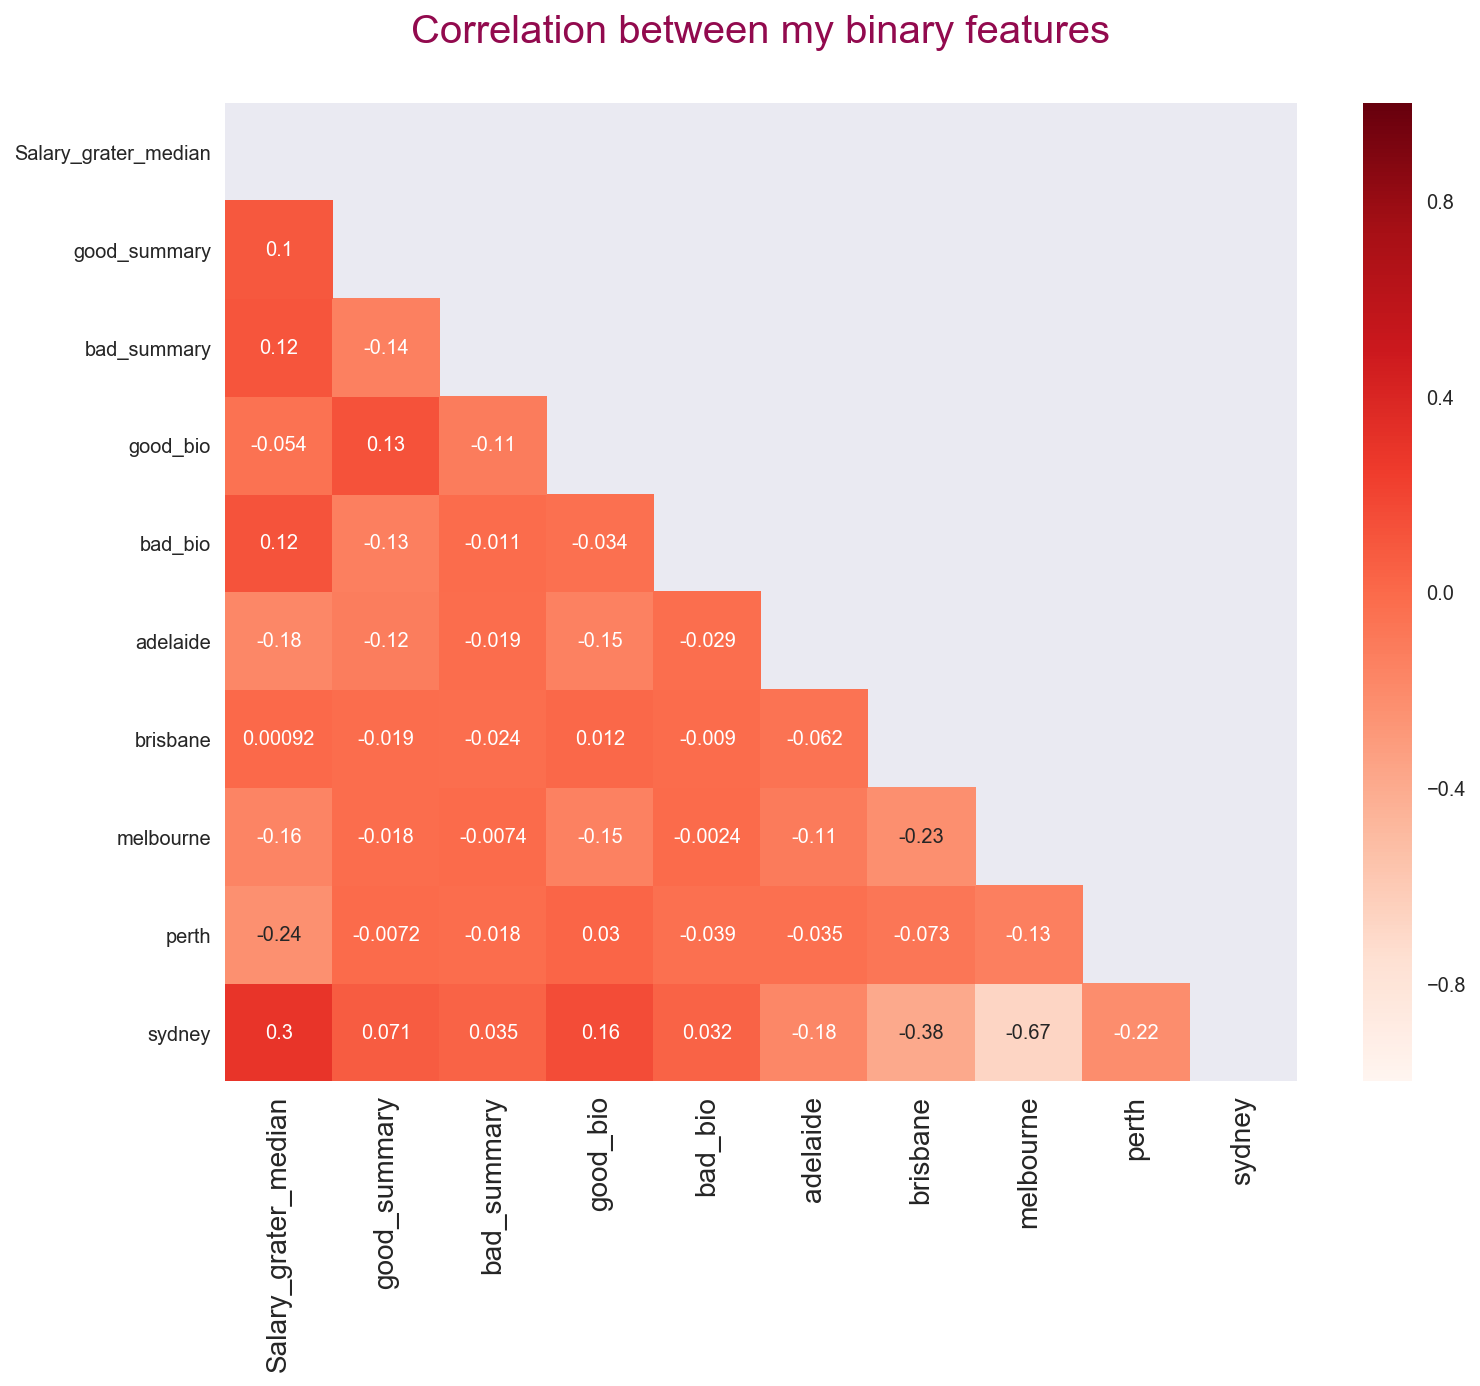

In [32]:
matrix = df2.corr() # get pearson r correlation 

fig, ax = plt.subplots(figsize=(12,9))
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.title('Correlation between my binary features', y=1.05, size = 20, color = '#920a4e')
ax = sns.heatmap(matrix, mask=mask, ax=ax, cmap='Reds', annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
#ax.hlines([0, 1], *ax.get_xlim(), colors='#0804f9')
#ax.vlines([11, 12], *ax.get_xlim(), colors='#0804f9')

plt.show()

# <span style="color:#735c12">Modeling

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">In this part I will use DecisionTreeClassifier, SVM, LogisticRegression to predict Job title.

In [33]:
# Using train test split, I split my data into train and test parts.
# -----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(df2, target, test_size=0.25, stratify=target, random_state=30)

In [34]:
# Just check my train and test splited data shapes. 
# -----------------------------------------------------
print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)
print('-----------------')
print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (286, 10)
X_test shape:  (96, 10)
-----------------
y_train shape:  (286,)
y_test shape:  (96,)


# <span style="color:#735c12">DecisionTreeClassifier

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">First check my baseline. My base line is 0.767. Then fit my DecisionTreeClassifier with max_depth = 3. In this case I don't use DecisionTreeRegression as all data set is binary. 

In [35]:
# Baseline 
bl = 1 - target.mean()
print('Baseline: ', bl)

Baseline:  0.7670157068062827


In [36]:
# I will use tree with depth 3, to see what I can get with it.
# -----------------------------------------------------
tree3 = DecisionTreeClassifier(max_depth=3)

In [37]:
# Fit my model with train data.
# -----------------------------------------------------
tree3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [38]:
tree3_scores = cross_val_score(tree3, X_train, y_train, cv = 6)
print (tree3_scores, np.mean(tree3_scores))

[0.75510204 0.8125     0.77083333 0.82978723 0.74468085 0.78723404] 0.7833562503015391


<span style="color:red">
--- comment ---

<span style="color:#1d5dec">After crossvalidation with 6 folds I got score for my DecisionTreeClassifier model 0.783 which is above my base line. Now I want to try use grid search and check if I could get better parameters. 

In [39]:
dtc_params = {
    'max_depth': range(1,20,2),
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_leaf': range(1, 5),
    'min_samples_split':range(10,500,20),
    'random_state':[123]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=12, verbose=1)

In [40]:
dtc_gs.fit(X_train, y_train)

Fitting 12 folds for each of 7000 candidates, totalling 84000 fits


[Parallel(n_jobs=1)]: Done 84000 out of 84000 | elapsed:  3.9min finished


GridSearchCV(cv=12, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 20, 2), 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_leaf': range(1, 5), 'min_samples_split': range(10, 500, 20), 'random_state': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [41]:
dtc_best = dtc_gs.best_estimator_
print (dtc_gs.best_params_)
print (dtc_gs.best_score_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'random_state': 123}
0.8181818181818182


In [42]:
# Check what fitures more important for my model. 
# -----------------------------------------------------
fi = pd.DataFrame({
        'feature':X_train.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
1,good_summary,0.535751
3,good_bio,0.260033
0,Salary_grater_median,0.102424
6,brisbane,0.069965
8,perth,0.017501
7,melbourne,0.009808
4,bad_bio,0.003594
5,adelaide,0.000924
2,bad_summary,0.000000
9,sydney,0.000000


In [43]:
prediction = dtc_gs.predict(X_test)

In [44]:
dtc_gs.score(X_test, y_test)

0.7708333333333334

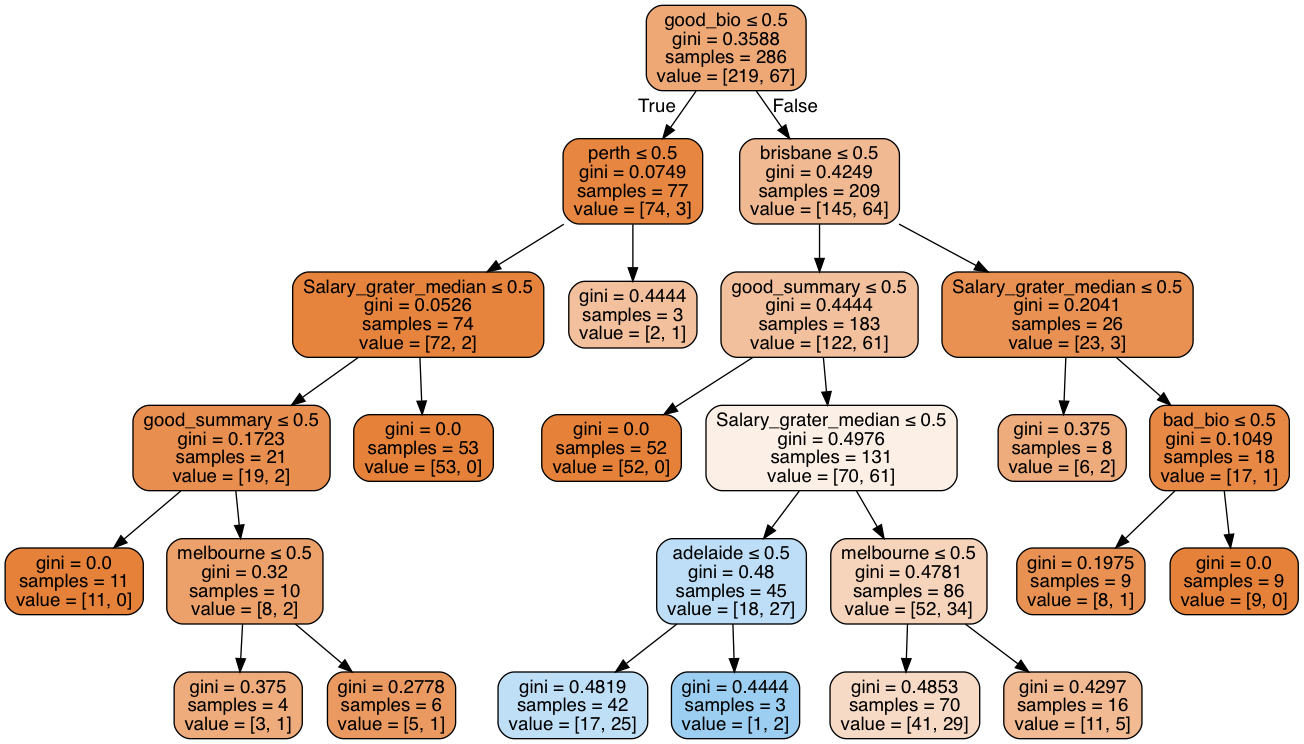

In [45]:
# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtr2
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtc_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_test.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> Grid search gave me better score 0.81. I use it to test on my test data and got result 0.77, I was expected better result but it is still above base line. Also I built DesisionTree graph depth = 5. Values < than 0.5 = 0 - related to busines analyst. and more than 0.5 = 1 - datascientist.  

In [46]:
#Create classification and confusion matrix for tree clasifier                 #TN     FP
                                                                               #FN     TP
# printing confusion matrix 
print(confusion_matrix(y_test, prediction,))    
print('')
#printing classification report
target_names = ['below_med', 'above_med']
print(classification_report(y_test, prediction, target_names = target_names))

[[68  6]
 [16  6]]

             precision    recall  f1-score   support

  below_med       0.81      0.92      0.86        74
  above_med       0.50      0.27      0.35        22

avg / total       0.74      0.77      0.74        96



# <span style="color:#735c12">LogisticRegression

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">I will build LogisticRegression in this part and check if I can get better result. I will use grid search as well. 

In [47]:
# Fit my LogisticRegression model.
# -----------------------------------------------------
lr = LogisticRegression(penalty='l1')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
lr.score(X_train, y_train)

0.8041958041958042

In [49]:
# Using GridSearch to see if there is better parameters for my model.
# -----------------------------------------------------
lr_params = {
    'penalty':['l1','l2'],
    'C':np.logspace(-4, 2, 40),
    'solver':['liblinear']
}

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=7, verbose=0)
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=7, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-04, 1.42510e-04, 2.03092e-04, 2.89427e-04, 4.12463e-04,
       5.87802e-04, 8.37678e-04, 1.19378e-03, 1.70125e-03, 2.42446e-03,
       3.45511e-03, 4.92388e-03, 7.01704e-03, 1.00000e-02, 1.42510e-02,
       2.03092e-02, 2.89427e-02, 4.12463e-...,
       2.42446e+01, 3.45511e+01, 4.92388e+01, 7.01704e+01, 1.00000e+02]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [50]:
best_lr = lr_gs.best_estimator_
print(lr_gs.best_params_)
print(lr_gs.best_score_)

{'C': 0.701703828670383, 'penalty': 'l1', 'solver': 'liblinear'}
0.8041958041958042


In [51]:
# Test my test data.
# -----------------------------------------------------
y_probs = lr_gs.predict(X_test)   
print("Score:", lr_gs.score(X_test, y_test))

Score: 0.7604166666666666


In [52]:
#Create classification and confusion matrix

               #TN     FP
               #FN     TP

# printing confusion matrix 
print(confusion_matrix(y_test, y_probs,))

#printing classification report
target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names = target_names))

[[68  6]
 [17  5]]
             precision    recall  f1-score   support

  below_med       0.80      0.92      0.86        74
  above_med       0.45      0.23      0.30        22

avg / total       0.72      0.76      0.73        96



<span style="color:red">
--- comment ---

<span style="color:#1d5dec">Using LR I got lower result and even below baseline 0.7604 . But with LR I managed predict datascientists = 5 also got wrong 6. With a dessision tree I didn't get any at all. 

# <span style="color:#735c12">SVM

In [53]:
rbf_model = SVC(kernel='rbf')
scores = cross_val_score(rbf_model, X_train, y_train , cv=5)
sm = scores.mean()
ss = scores.std()
print(scores)
print('Average score: {:0.3} +/- {:0.3}'.format(sm, ss))

[0.75862069 0.75862069 0.77192982 0.77192982 0.76785714]
Average score: 0.766 +/- 0.00604


In [54]:
svc_params = {
    'C':np.logspace(-3, 2, 10),
    'gamma':np.logspace(-5, 2, 10),
    'kernel':['linear','rbf'],
}

svc_gs = GridSearchCV(SVC(), svc_params, cv=7, verbose=1)
svc_gs.fit(X_train, y_train)


best_svc = svc_gs.best_estimator_
print(svc_gs.best_params_)
print(svc_gs.best_score_)

Fitting 7 folds for each of 200 candidates, totalling 1400 fits
{'C': 0.5994842503189409, 'gamma': 1e-05, 'kernel': 'linear'}
0.7902097902097902


[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    6.3s finished


In [55]:
# Test my SVM model on test data.
# -----------------------------------------------------
y_probs = svc_gs.predict(X_test)   
print("Score:", svc_gs.score(X_test, y_test))

Score: 0.7708333333333334


In [56]:
#Create classification and confusion matrix

               #TN     FP
               #FN     TP

# printing confusion matrix 
print(confusion_matrix(y_test, y_probs,))

#printing classification report
target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names = target_names))

[[68  6]
 [16  6]]
             precision    recall  f1-score   support

  below_med       0.81      0.92      0.86        74
  above_med       0.50      0.27      0.35        22

avg / total       0.74      0.77      0.74        96



<span style="color:red">
--- comment ---

<span style="color:#1d5dec">With SVM I got result 0.7708 which is slightly better than base line. But I got best result so far for my confusion matrix. 

# <span style="color:#735c12">KNN

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">I will try is KNN, and I want to see if I can get result any better than after SVM.  

In [57]:
knn_params = {
    'n_neighbors':list(range(25,30)),
    'weights':['distance','uniform'],
    'leaf_size' : [5,6,7],
    'algorithm' : ['auto', 'ball_tree','kd_tree','brute'],
    'n_jobs':[-1]
}

knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=7, verbose=1)
knn_gs.fit(X_train, y_train)


knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_)
print(knn_gs.best_score_)

Fitting 7 folds for each of 120 candidates, totalling 840 fits
{'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 27, 'weights': 'uniform'}
0.8076923076923077


[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  4.3min finished


In [58]:
# Test my test data.
# -----------------------------------------------------
y_probs = knn_gs.predict(X_test)   
print("Score:", knn_gs.score(X_test, y_test))

Score: 0.7708333333333334


In [59]:
#Create classification and confusion matrix

               #TN     FP
               #FN     TP

# printing confusion matrix 
print(confusion_matrix(y_test, y_probs,))

#printing classification report
target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names = target_names))

[[65  9]
 [13  9]]
             precision    recall  f1-score   support

  below_med       0.83      0.88      0.86        74
  above_med       0.50      0.41      0.45        22

avg / total       0.76      0.77      0.76        96



<span style="color:red">
--- comment ---

<span style="color:#1d5dec">With KNN I got more data scientist job predicted. And knn score is grater than base line 0.7708

# <span style="color:#735c12">RandomForestClassifier

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">I tried RandomForestClassifier with a GridSearch. I know that RandomForestClassifire not realy senetive to hiperparameters but I use it nayway and got result similar to KNN but with KNN I got less False positive predictions. 0.83 score its more than with KNN.

In [76]:
#making the instance
model=RandomForestClassifier()
#hyper parameters set
params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,30],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
Rforest = GridSearchCV(model, param_grid=params, n_jobs=-1)

In [77]:
# Fit my model
# -----------------------------------------------------
Rforest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [10, 15, 20, 25, 30], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [3, 4, 5, 6, 7], 'random_state': [123], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [78]:
print("Best Hyper Parameters:\n",Rforest.best_params_)

Best Hyper Parameters:
 {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 25, 'n_jobs': -1, 'random_state': 123}


In [79]:
# Check score fo my model on test data.
# -----------------------------------------------------
print("Score:", Rforest.score(X_train, y_train))

Score: 0.8356643356643356


In [64]:
#Prediction
prediction=Rforest.predict(X_test)

In [65]:
# Evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
# Evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,y_test))

Accuracy: 0.78125
Confusion Metrix:
 [[66 13]
 [ 8  9]]


<span style="color:red">
--- comment ---

<span style="color:#1d5dec">I put some more information about everything above in my technical report, link you can find on top of this document.

<img src="results.png">